In [11]:
print(__doc__)

# Standard
from pathlib import Path
import os
import sys
import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

# `DatasetLoader` is a custom helper class to retrieve data from hdf5 file
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utility.dataset_loader_hdf5 import DatasetLoader

# Global utitlity functions are in separate notebook
%run ../utils.ipynb

Automatically created module for IPython interactive environment


In [27]:
# Various Settings
TABLE_NAME = "sensors_100hz"  # Table with raw sensor data
HMOG_HDF5 = Path.cwd().parent /".."/ "data" / "processed" / "hmog_dataset.hdf5"
SEED = 712

feature_cols=[
        "acc_x",
        "acc_y",
        "acc_z",
]

window_size = 50
step_width = 50

# For plots and CSVs
OUTPUT_PATH = Path.cwd() / "output" / "chapter-6-1-3-ocsvm"
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
REPORT_PATH = Path.cwd().parent / "reports" / "figures" # Figures for thesis

In [3]:
#load the dataset
hmog = DatasetLoader(
    hdf5_file=HMOG_HDF5,
    table_name=TABLE_NAME,
    max_subjects=10,
    task_types=[],
    exclude_subjects=["733162", "526319", "796581"],   
    exclude_cols=[],
    seed=SEED,
)
hmog.data_summary()



,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,all,835.02,13681006,7,10,240
1,index,0.09,2328,4,97,2328


In [4]:
#Test and Train
hmog.split_train_test(5)
hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,index,0.09,2328,4,97,2328
1,train,397.11,6506308,7,5,120
2,test,437.91,7174698,7,5,120


In [5]:
hmog.train['subject'].unique()

array(['405035', '248252', '171538', '326223', '261313'], dtype=object)

In [6]:
hmog.test['subject'].unique()

array(['368258', '777078', '527796', '396697', '540641'], dtype=object)

In [7]:
X_train = hmog.train.query('subject == "405035"')
X_train.head()

,acc_x,acc_y,acc_z,sys_time,subject,session,task_type
0,1.084573,7.547721,6.539762,1398555056760,405035,405035_session_18,5
1,1.082559,7.551590,6.532594,1398555056770,405035,405035_session_18,5
2,1.080544,7.555458,6.525426,1398555056780,405035,405035_session_18,5
3,1.078529,7.559327,6.518258,1398555056790,405035,405035_session_18,5
4,1.076515,7.563196,6.511090,1398555056800,405035,405035_session_18,5


## Reshape

In [14]:
df_train_valid = utils_reshape_features(
    hmog.train,
    feature_cols=feature_cols,
    window_size=window_size,
    step_width=step_width,
)

# Clean memory
del hmog.train
%reset_selective -f hmog.train

print("Validation data after reshaping:")
display(df_train_valid.head())

# Store iterim data
df_train_valid.to_msgpack(OUTPUT_PATH / "df_train_valid.msg")

# Clean memory
%reset_selective -f df_train_valid

AttributeError: 'DatasetLoader' object has no attribute 'train'

In [24]:
#print("Validation data after reshaping:")
#display(df_train_valid.tail(20))
df_train_valid.iloc[0]

X            [[-0.7290344, 2.9191303, 8.397662], [-0.811378...
subject                                                 171538
session                                       171538_session_1
task_type                                                    6
Name: 0, dtype: object

In [26]:
df_train_test = utils_reshape_features(
    hmog.test,
    feature_cols=feature_cols,
    window_size=window_size,
    step_width=step_width,
)

del hmog.test
%reset_selective -f hmog.test

print("Testing data after reshaping:")
display(df_train_test.head())

# Store iterim data
df_train_test.to_msgpack(OUTPUT_PATH / "df_train_test.msg")

# Clean memory
%reset_selective -f df_train_test

Testing data after reshaping:


,X,subject,session,task_type
0,"[[-1.1456255, 5.394735, 7.799111999999999], [-...",368258,368258_session_1,1
1,"[[-1.084274060443264, 5.301660367621376, 7.530...",368258,368258_session_1,1
2,"[[-1.6317807384260268, 5.45671824430848, 7.345...",368258,368258_session_1,1
3,"[[-1.69838728287104, 5.7520687338559995, 7.161...",368258,368258_session_1,1
4,"[[-1.89605803914624, 5.69984627934208, 7.30545...",368258,368258_session_1,1


NameError: name 'OUTPUT_PATH' is not defined

In [59]:
# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

ValueError: could not convert string to float: '405035_session_1'

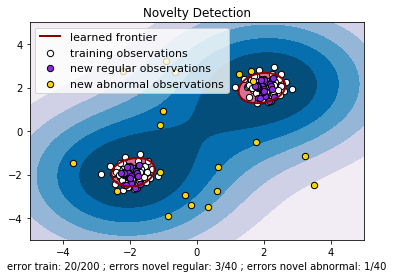

In [5]:
# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()